In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
data = pd.read_excel('windmill.xlsx')

In [4]:
data.head()

,Date,Time_Block,AvgPowerKW,AvgWindSpeed,WindDirection
0,2024-01-31,23:50:00,358.48,5.43,3.5
1,2024-01-31,23:40:00,34.33,3.03,-3.5
2,2024-01-31,23:30:00,86.23,3.39,-8.4
3,2024-01-31,23:20:00,NaN,2.82,15.4
4,2024-01-31,23:10:00,NaN,2.62,-23.7


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26493 entries, 0 to 26492
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           26493 non-null  datetime64[ns]
 1   Time_Block     26493 non-null  object        
 2   AvgPowerKW     23302 non-null  float64       
 3   AvgWindSpeed   25093 non-null  float64       
 4   WindDirection  26266 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.0+ MB


In [8]:
data.describe()

,Date,AvgPowerKW,AvgWindSpeed,WindDirection
count,26493,23302.000000,25093.000000,26266.000000
mean,2023-10-31 12:57:09.192616960,579.223044,5.381927,0.750293
min,2023-08-01 00:00:00,-22.700000,0.000000,-176.100000
25%,2023-09-15 00:00:00,148.987500,3.740000,-5.100000
50%,2023-11-01 00:00:00,436.390000,5.370000,-0.800000
75%,2023-12-17 00:00:00,886.445000,6.910000,5.000000
max,2024-01-31 00:00:00,2143.900000,17.790000,178.600000
std,NaN,514.576921,2.021963,17.609298


In [13]:
#Total Null values inside AvgPowerKW. this null values should be handled before apply this data into the model
print("AvgPowerKW column total NULL values: ",data['AvgPowerKW'].isnull().sum())
print("AvgWindSpeed columns total NULL values: ",data['AvgWindSpeed'].isnull().sum())
print("WindDirection columns total NULL values: ",data['WindDirection'].isnull().sum())

AvgPowerKW column total NULL values:  3191
AvgWindSpeed columns total NULL values:  1400
WindDirection columns total NULL values:  227


### the datasheet contains 6,493 entries with five columns: Date, Time_Block, AvgPowerKW, AvgWindSpeed, and WindDirection
Date and Time_Block are present for all entries, indicating no missing timestamps.
AvgPowerKW (average power in kilowatts) has 3,191 missing values.
AvgWindSpeed has 1,400 missing values.
WindDirection has 227 missing values.

<p>an imputation strategy that accounts for time series characteristics since both the AvgPowerKW and AvgWindSpeed data are missing in some instances. Before deciding on the imputation method, let's further explore the data to understand the pattern of these missing values. This exploration can help identify if the missingness is random or follows a pattern, which is crucial for selecting the most appropriate imputation technique. </p>

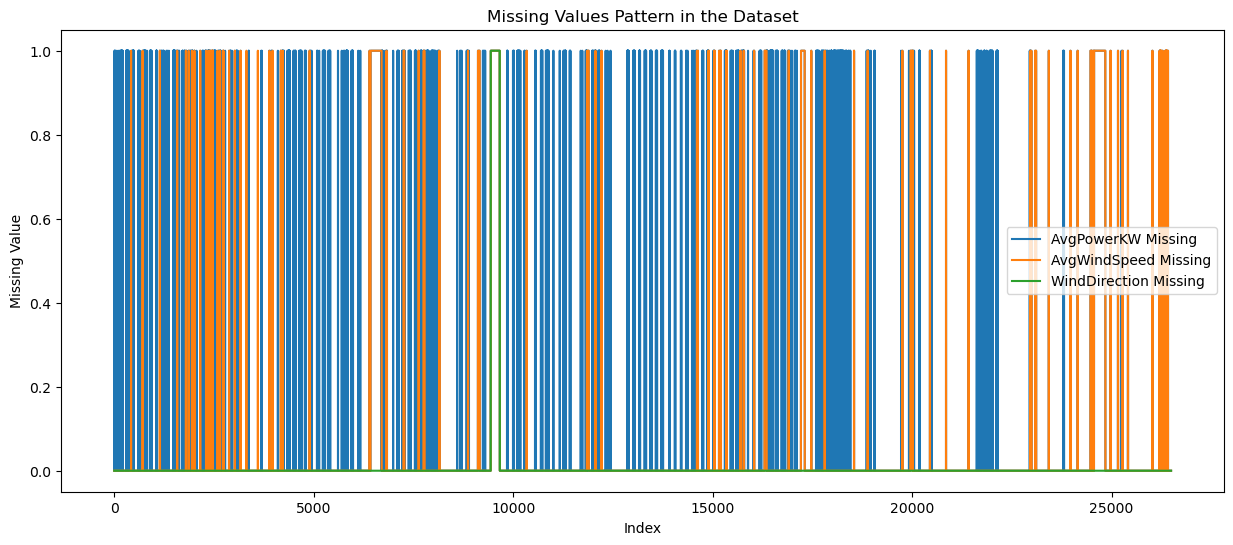

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(data['AvgPowerKW'].isnull(), label='AvgPowerKW Missing')
plt.plot(data['AvgWindSpeed'].isnull(), label='AvgWindSpeed Missing')
plt.plot(data['WindDirection'].isnull(), label='WindDirection Missing')
plt.legend()
plt.title('Missing Values Pattern in the Dataset')
plt.ylabel('Missing Value')
plt.xlabel('Index')
plt.show()

The plot illustrates the distribution of missing values across AvgPowerKW, AvgWindSpeed, and WindDirection in the dataset. Here are some observations:</br>

Missing values in AvgPowerKW are quite spread throughout the dataset but appear to cluster in certain areas, suggesting periods of time with more frequent data gaps.</br>
AvgWindSpeed and WindDirection also show missing values, with AvgWindSpeed missing values appearing slightly less frequently than AvgPowerKW.</br>
The distribution of missing WindDirection values is sparse compared to the other two, indicating that wind direction data is more consistently available.</br>
Given these patterns, choosing an imputation method that respects the temporal nature of the data and possibly the relationships between these variables would be wise.</br> 
For example:</br>

Temporal Interpolation (like linear interpolation) could be an excellent first approach for filling gaps in AvgPowerKW and AvgWindSpeed, assuming that values change relatively smoothly over short periods (like 10-minute intervals).</br>


In [18]:
data['AvgPowerKW'] = data['AvgPowerKW'].interpolate(method='linear')
data['AvgWindSpeed'] = data['AvgWindSpeed'].interpolate(method='linear')
data['WindDirection'] = data['WindDirection'].fillna(method='ffill')

# Checking for any remaining missing values after imputation
remaining_missing = data.isnull().sum()

# Display the first few rows after imputation to verify
sample_after_imputation = data.head(), remaining_missing

sample_after_imputation

(        Date Time_Block  AvgPowerKW  AvgWindSpeed  WindDirection
 0 2024-01-31   23:50:00     358.480          5.43            3.5
 1 2024-01-31   23:40:00      34.330          3.03           -3.5
 2 2024-01-31   23:30:00      86.230          3.39           -8.4
 3 2024-01-31   23:20:00      68.062          2.82           15.4
 4 2024-01-31   23:10:00      49.894          2.62          -23.7,
 Date             0
 Time_Block       0
 AvgPowerKW       0
 AvgWindSpeed     0
 WindDirection    0
 dtype: int64)

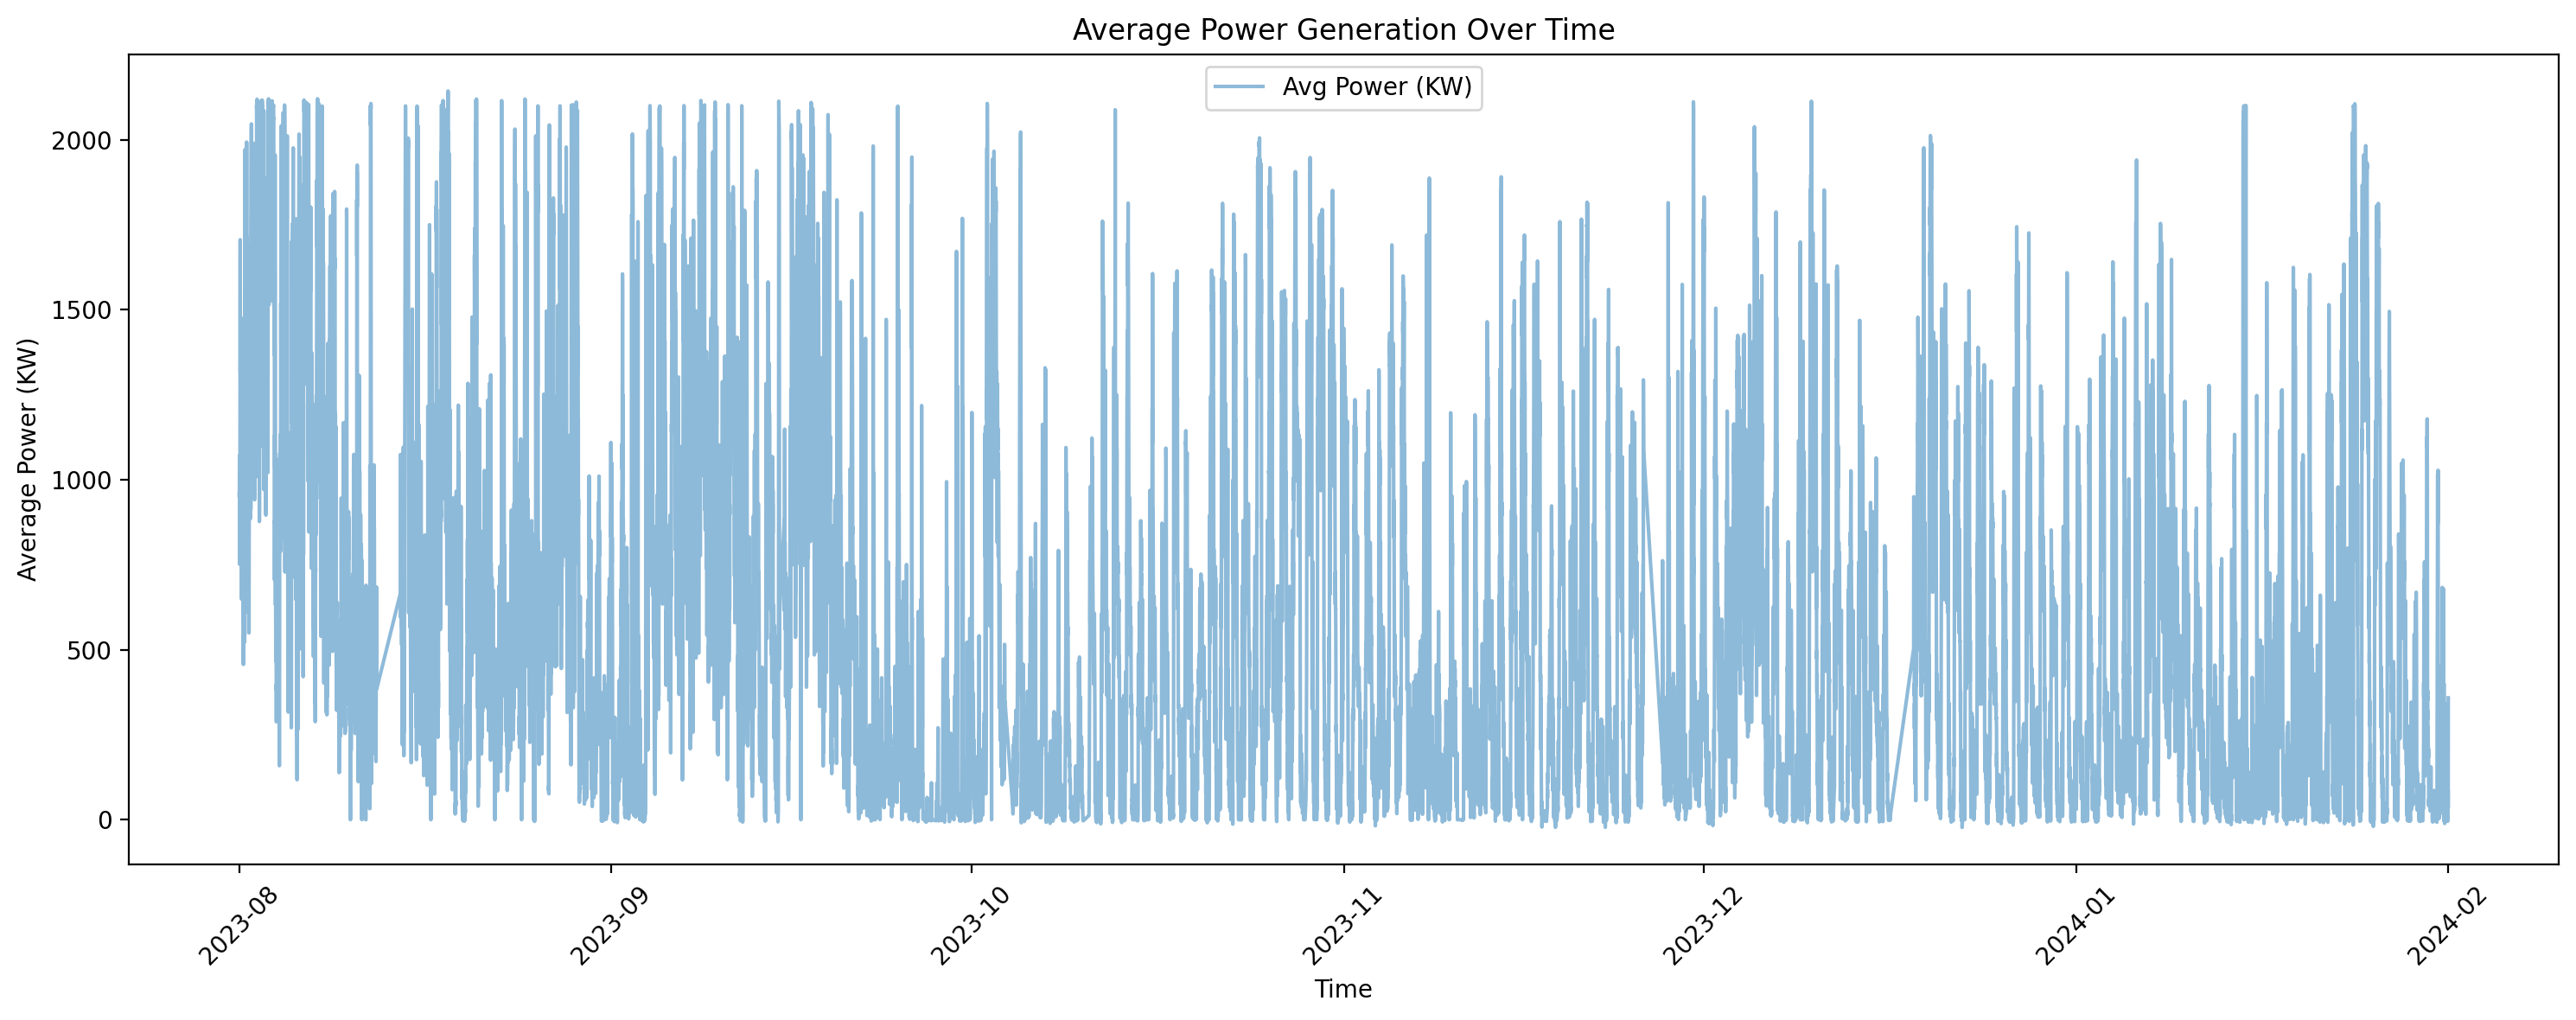

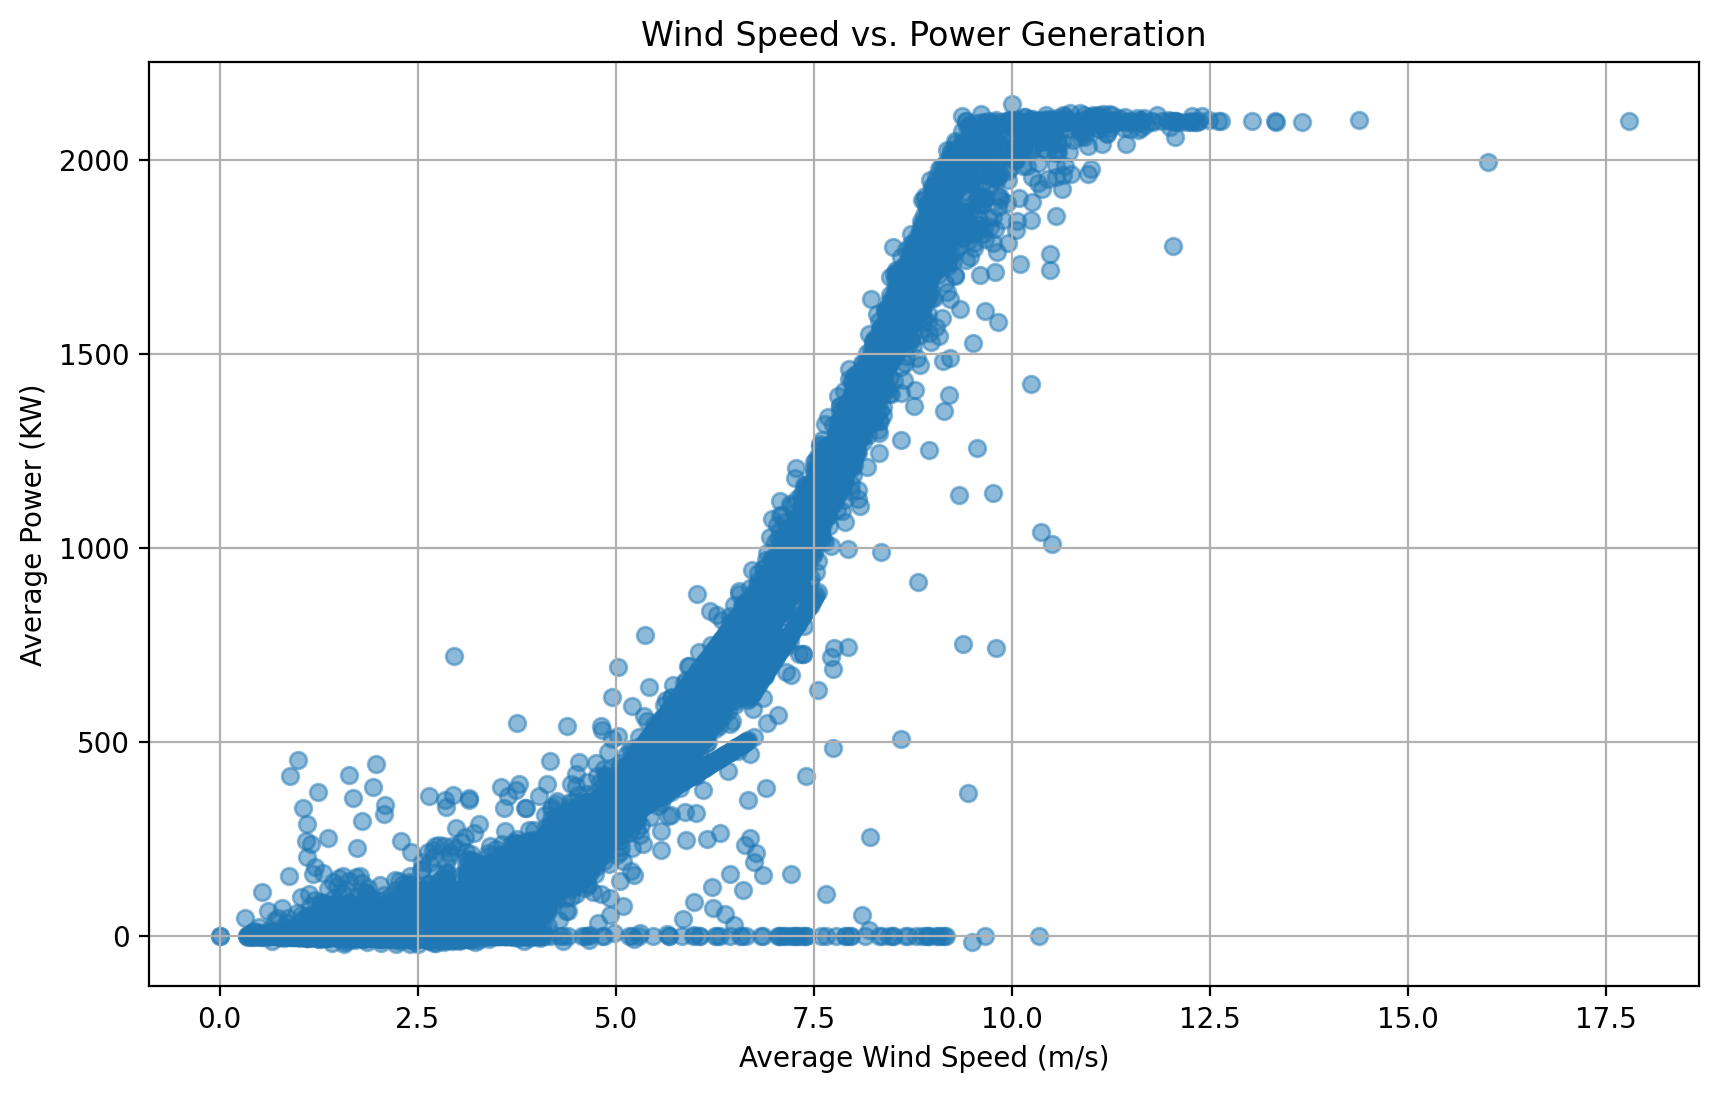

In [43]:
data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time_Block'].astype(str))

# Sorting the dataframe by DateTime
data.sort_values('DateTime', inplace=True)

# Plot 1: Trends over Time
plt.figure(figsize=(15, 6),dpi=200)
plt.plot(data['DateTime'], data['AvgPowerKW'], label='Avg Power (KW)', alpha=0.5)
plt.title('Average Power Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Average Power (KW)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

# Plot 2: Wind Speed vs. Power Generation
plt.figure(figsize=(10, 6),dpi=200)
plt.scatter(data['AvgWindSpeed'], data['AvgPowerKW'], alpha=0.5)
plt.title('Wind Speed vs. Power Generation')
plt.xlabel('Average Wind Speed (m/s)')
plt.ylabel('Average Power (KW)')
plt.grid(True)

plt.show()

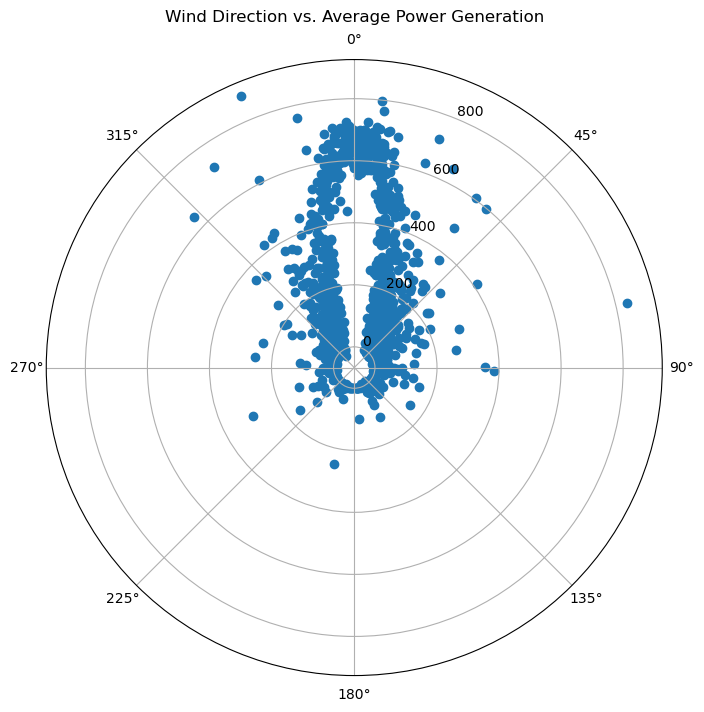

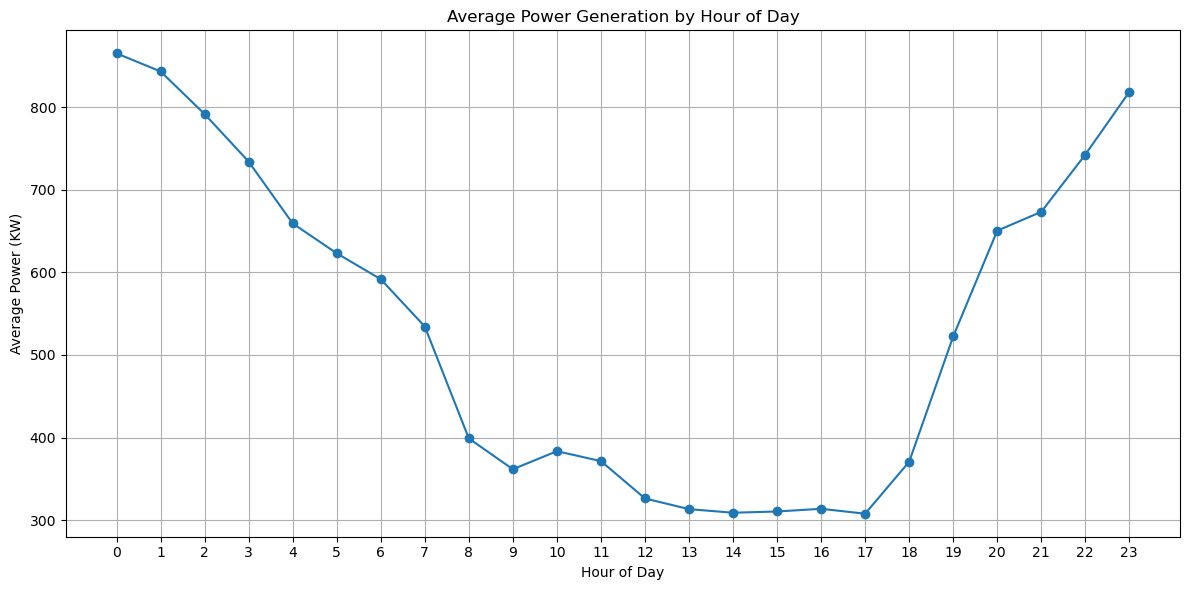

In [24]:
# 3. Wind Direction Impact
# Grouping data by WindDirection and calculating mean AvgPowerKW for each direction
wind_direction_power = data.groupby('WindDirection')['AvgPowerKW'].mean().reset_index()

# Converting WindDirection to radians for polar plot
wind_direction_power['WindDirectionRad'] = np.deg2rad(wind_direction_power['WindDirection'])

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.scatter(wind_direction_power['WindDirectionRad'], wind_direction_power['AvgPowerKW'])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Wind Direction vs. Average Power Generation', va='bottom')

# 4. Daily Patterns
# Extracting hour from DateTime
data['Hour'] = data['DateTime'].dt.hour

# Grouping by hour to get average power generation per hour
hourly_avg_power = data.groupby('Hour')['AvgPowerKW'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_power['Hour'], hourly_avg_power['AvgPowerKW'], marker='o')
plt.title('Average Power Generation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (KW)')
plt.grid(True)
plt.xticks(hourly_avg_power['Hour'])

plt.tight_layout()
plt.show()

Wind Direction vs. Average Power Generation (Polar Plot): This visualization shows the relationship between wind direction (in degrees) and average power generation. It highlights how certain wind directions may correlate with higher or lower power outputs, suggesting that wind turbines might have directional efficiencies based on prevailing wind patterns.

Average Power Generation by Hour of Day: This plot illustrates the daily cycle of power generation, showing average power output for each hour of the day. Such patterns can reveal peak production times, which may align with certain wind conditions or demand periods.

In [25]:
from scipy.stats import pearsonr
import statsmodels.api as sm

# Correlation Analysis
correlation_wind_speed = pearsonr(data['AvgWindSpeed'], data['AvgPowerKW'])[0]
correlation_wind_direction = pearsonr(data['WindDirection'], data['AvgPowerKW'])[0]

# Regression Analysis: AvgPowerKW ~ AvgWindSpeed
X = sm.add_constant(data['AvgWindSpeed'])  # adding a constant
y = data['AvgPowerKW']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)  # making predictions

# Summary of the regression model
model_summary = model.summary()

correlation_wind_speed, correlation_wind_direction, model_summary

(0.9376037229480084,
 -0.055201211828281874,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             AvgPowerKW   R-squared:                       0.879
 Model:                            OLS   Adj. R-squared:                  0.879
 Method:                 Least Squares   F-statistic:                 1.926e+05
 Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
 Time:                        16:33:55   Log-Likelihood:            -1.7482e+05
 No. Observations:               26493   AIC:                         3.496e+05
 Df Residuals:                   26491   BIC:                         3.497e+05
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------

## Correlation Analysis:

The correlation coefficient between AvgWindSpeed and AvgPowerKW is approximately 0.938, indicating a very strong positive relationship. This suggests that as wind speed increases, power generation also increases, which is expected for wind turbines.
The correlation between WindDirection and AvgPowerKW is around -0.055, indicating a very weak inverse relationship.</br>
This suggests that wind direction has little to no direct effect on the power generation, at least not linearly.

## Regression Analysis:

The regression model, with AvgPowerKW as the dependent variable and AvgWindSpeed as the independent variable, has an R-squared value of 0.879. This means that approximately 87.9% of the variability in power generation can be explained by wind speed alone, highlighting the significant impact of wind speed on power output.</br>
The model coefficients are as follows:</br>
Intercept (const): -749.7231, indicating the expected value of AvgPowerKW when AvgWindSpeed is 0. This negative value may reflect the baseline power consumption or losses when no power is being generated.</br>
AvgWindSpeed: 238.7244, meaning for each one unit increase in wind speed, power generation increases by approximately 238.72 KW, underlining the positive impact of wind speed on power generation.</br>
Given the high correlation with wind speed and the significant explanatory power of the regression model, it's clear that wind speed is a critical factor in power generation. Low power generation could be attributed to low wind speeds based on this analysis. However, instances of low power generation not explained by wind speed may require further investigation into operational, maintenance, or technical issues.

In [36]:
# Feature Engineering
data['DateTime'] = pd.to_datetime(data['DateTime'])  # Ensuring DateTime is in datetime format
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Month'] = data['DateTime'].dt.month

# Preparing the features and target variable
X = data[['AvgWindSpeed', 'Hour', 'DayOfWeek', 'Month']]  # Now including time-related features
y = data['AvgPowerKW']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predicting
y_pred_rf = model_rf.predict(X_test)

# Calculating error metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse_rf}")

Random Forest - Mean Absolute Error (MAE): 34.765646028251986
Random Forest - Mean Squared Error (MSE): 7233.505342300246
Random Forest - Root Mean Squared Error (RMSE): 85.05001670958241


In [40]:

def predict_power_generation_with_input(model_rf):
    # User inputs
    date_time_str = input("Enter future date and time (YYYY-MM-DD HH:MM): ")
    avg_wind_speed = float(input("Enter estimated average wind speed (in m/s): "))
    
    # Converting string to datetime
    date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
    
    # Extracting features from datetime
    hour = date_time.hour
    day_of_week = date_time.weekday()
    month = date_time.month
    
    # Creating a feature array for prediction (reshape for a single sample)
    features = np.array([[avg_wind_speed, hour, day_of_week, month]])
    
    # Predicting power generation
    predicted_power = model_rf.predict(features)
    
    print(f"Predicted Power Generation: {predicted_power[0]} KW")


predict_power_generation_with_input(model_rf)


Enter future date and time (YYYY-MM-DD HH:MM): 2024-06-01 15:00
Enter estimated average wind speed (in m/s): 6.02
Predicted Power Generation: 586.0589094124211 KW


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



# Step 1: Feature Engineering
data['DateTime'] = pd.to_datetime(data['DateTime'])  # Ensure DateTime is in datetime format
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Month'] = data['DateTime'].dt.month

# Step 2: Prepare the Data
X = data[['Hour', 'DayOfWeek', 'Month']]  # Predictors
y = data['AvgWindSpeed']  # Target

# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1.2568715700243864
Mean Squared Error (MSE): 2.5824014214608835
Root Mean Squared Error (RMSE): 1.6069851964037762


In [39]:
def predict_wind_speed(model):
    """
    Predicts wind speed based on user input for date and time.
    
    Parameters:
    - model: The trained Random Forest model.
    """
    # User inputs
    date_time_str = input("Enter the date and time (YYYY-MM-DD HH:MM): ")
    
    # Converting string to datetime
    date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
    
    # Extracting features from datetime
    hour = date_time.hour
    day_of_week = date_time.weekday()
    month = date_time.month
    
    # Creating a feature array for prediction (reshape for a single sample)
    features = np.array([[hour, day_of_week, month]])
    
    # Predicting wind speed
    predicted_wind_speed = model.predict(features)
    
    print(f"Predicted Wind Speed: {predicted_wind_speed[0]} m/s")

predict_wind_speed(model)


Enter the date and time (YYYY-MM-DD HH:MM): 2024-06-01 15:00
Predicted Wind Speed: 6.078924198933603 m/s


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
